# Redes Neuronales - LTSM

In [4]:
import pandas as pd # Data handling and managing
import numpy as np  # Handiling linear Algera
import seaborn as sn
import datetime 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import pmdarima as pm

%matplotlib inline

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras import optimizers

<ipython-input-4-09d8370b4454>:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [3]:
dataset=pd.read_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Dataset_Completo_Fase2.xlsx')
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana
0,2015-06-29,1,3629,0,4.394742,0,0
1,2015-06-30,1,4666,0,4.394742,0,0
2,2015-07-01,1,16070,0,4.394742,0,0
3,2015-07-02,1,4666,0,4.394742,0,0
4,2015-07-03,1,8813,0,4.394742,0,0
...,...,...,...,...,...,...,...
140541,2021-03-19,99,540,0,4.394742,0,0
140542,2021-03-20,99,0,0,4.394742,0,1
140543,2021-03-21,99,0,0,4.394742,0,1
140544,2021-03-22,99,0,0,4.394742,0,0


In [5]:
Q1_ventas=dataset['udsVenta'].quantile(0.25)
Q3_ventas=dataset['udsVenta'].quantile(0.75)
IQR_ventas=Q3_ventas-Q1_ventas

Limit_lower=Q1_ventas-(1.5*IQR_ventas)
Limit_upper=Q3_ventas+(1.5*IQR_ventas)

dataset=dataset[~((dataset["udsVenta"] < Limit_lower) |(dataset["udsVenta"] > Limit_upper))]


Q1_precios=dataset['Precio'].quantile(0.25)
Q3_precios=dataset['Precio'].quantile(0.75)
IQR_precios=Q3_precios-Q1_precios

Limit_lower_precios=Q1_precios-(1.5*IQR_precios)
Limit_upper_precios=Q3_precios+(1.5*IQR_precios)

dataset=dataset[~((dataset["Precio"] < Limit_lower_precios) |(dataset["Precio"] > Limit_upper_precios))]

In [6]:
X_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1)
y_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019'), 'udsVenta']

X_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1).reset_index(drop=True)
y_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019'), 'udsVenta'].reset_index(drop=True)

In [7]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (94757, 5, 1)
Validation set shape (25842, 5, 1)


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def build_classifier(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(units = 50,activation='relu',input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer, metrics = ['mean_squared_error'])
    return grid_model

grid_model = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size' : [128,256,512],
              'epochs' : [10,50,100],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 2)


grid_search = grid_search.fit(X_train_series,y_train)

In [ ]:
best_parameters

In [11]:
epochs = 100
batch = 128
lr = 0.0003
adam = optimizers.Adam(lr)

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [12]:
lstm_history = model_lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/100
2962/2962 - 7s - loss: 201213.7969 - val_loss: 222984.8594
Epoch 2/100
2962/2962 - 6s - loss: 180956.5781 - val_loss: 219038.4375
Epoch 3/100
2962/2962 - 5s - loss: 149642.1719 - val_loss: 208774.2656
Epoch 4/100
2962/2962 - 5s - loss: 115862.9219 - val_loss: 176992.9375
Epoch 5/100
2962/2962 - 5s - loss: 111071.0156 - val_loss: 194935.0312
Epoch 6/100
2962/2962 - 5s - loss: 110426.8828 - val_loss: 174605.1406
Epoch 7/100
2962/2962 - 5s - loss: 108553.4141 - val_loss: 207683.4844
Epoch 8/100
2962/2962 - 5s - loss: 108449.2266 - val_loss: 192361.2031
Epoch 9/100
2962/2962 - 5s - loss: 107845.0078 - val_loss: 199120.9219
Epoch 10/100
2962/2962 - 5s - loss: 107384.1953 - val_loss: 181467.7500
Epoch 11/100
2962/2962 - 5s - loss: 107219.9453 - val_loss: 191821.7500
Epoch 12/100
2962/2962 - 5s - loss: 106738.9453 - val_loss: 175340.1250
Epoch 13/100
2962/2962 - 5s - loss: 106678.6641 - val_loss: 186419.0625
Epoch 14/100
2962/2962 - 5s - loss: 106370.1562 - val_loss: 180634.4375
E

In [13]:
y_pred=lstm_history.model.predict(X_test_series)

Resultat=X_test
Resultat['y_test']=y_test
Resultat['y_pred']=y_pred
Resultat

,Producto,flag,Precio,Festivo,Fin de semana,y_test,y_pred
0,1,0,3.910500,0,0,691,954.729187
1,1,0,3.910500,1,0,0,229.089935
2,1,0,3.910500,0,1,346,288.879944
3,1,0,3.910500,0,1,0,288.879944
4,1,0,3.910500,1,0,0,229.089935
...,...,...,...,...,...,...,...
25837,99,0,4.394742,0,0,540,202.493195
25838,99,0,4.394742,0,1,0,33.474457
25839,99,0,4.394742,0,1,0,33.474457
25840,99,0,4.394742,0,0,0,202.493195


In [20]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_test_series)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, lstm_valid_pred)))

Train rmse: 315.92963643229916
Validation rmse: 428.15313105984166


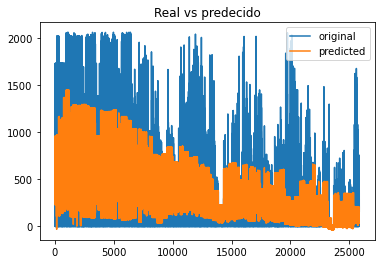

In [22]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Real vs predecido")
plt.legend()
plt.show()

In [54]:
import shap


shap_values = shap.TreeExplainer(model_lstm).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Exception: Model type not yet supported by TreeExplainer: <class 'tensorflow.python.keras.engine.sequential.Sequential'>

# Redes Neuronales con variables extra

In [23]:
import pandas as pd # Data handling and managing
import numpy as np  # Handiling linear Algera
import seaborn as sn
import datetime 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import pmdarima as pm


from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from keras import optimizers

%matplotlib inline

<ipython-input-23-d9779e0d52d9>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [24]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [36]:
dataset=pd.read_excel(r'C:\Users\subir\OneDrive\Escritorio\PC ANTIC\UOC\TFM\Dataset_Completo_Fase3.xlsx')
dataset.drop(dataset.columns[0], axis=1, inplace=True)
dataset

,Fecha,Producto,udsVenta,flag,Precio,Festivo,Fin de semana,sales_lag_7,sales_lag_15,sales_lag_30,...,sales_lag_300,sales_lag_330,sales_lag_360,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,Mes,Dia,DiaDeLaSemana,Año
0,2019-02-20,1,1555,0,4.138200,0,0,0,1555,518,...,0,0,0,121.425704,94.570180,86.954522,2,20,2,2019
1,2019-02-23,1,1037,0,4.138200,0,1,1037,1037,0,...,0,0,0,122.785716,95.307368,87.471774,2,23,5,2019
2,2019-02-24,1,0,0,4.138200,0,1,0,0,0,...,0,0,0,124.180002,96.063975,88.001770,2,24,6,2019
3,2019-02-27,1,1037,0,4.138200,0,0,518,1037,0,...,0,0,0,125.577704,96.826398,88.532477,2,27,2,2019
4,2019-03-02,1,518,0,4.138200,0,1,0,0,1037,...,0,0,0,127.009914,97.594623,89.063859,3,2,5,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105951,2021-03-19,99,540,0,4.394742,0,0,0,0,756,...,0,0,0,198.518439,218.510439,201.719088,3,19,4,2021
105952,2021-03-20,99,0,0,4.394742,0,1,0,0,0,...,540,0,108,197.608648,218.441607,201.748880,3,20,5,2021
105953,2021-03-21,99,0,0,4.394742,0,1,0,0,0,...,0,0,0,196.698856,218.366616,201.782522,3,21,6,2021
105954,2021-03-22,99,0,0,4.394742,0,0,0,0,0,...,810,0,0,195.789065,218.287277,201.817988,3,22,0,2021


In [37]:
Q1_precios=dataset['Precio'].quantile(0.25)
Q3_precios=dataset['Precio'].quantile(0.75)
IQR_precios=Q3_precios-Q1_precios

Limit_lower_precios=Q1_precios-(1.5*IQR_precios)
Limit_upper_precios=Q3_precios+(1.5*IQR_precios)

dataset=dataset[~((dataset["Precio"] < Limit_lower_precios) |(dataset["Precio"] > Limit_upper_precios))]

In [ ]:
#Solo para buscar parametros optimos
#dataset = dataset.sample(frac=0.20)

In [38]:
#X_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1)
#y_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2019'), 'udsVenta']

#X_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019')].drop(['Fecha','udsVenta'], axis=1).reset_index(drop=True)
#y_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2019'), 'udsVenta'].reset_index(drop=True)



X_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2018')].drop(['Fecha','udsVenta'], axis=1)
y_train = dataset.loc[dataset['Fecha'] < pd.to_datetime('December 30, 2018'), 'udsVenta']

X_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2018')].drop(['Fecha','udsVenta'], axis=1).reset_index(drop=True)
y_test = dataset.loc[dataset['Fecha'] >= pd.to_datetime('December 30, 2018'), 'udsVenta'].reset_index(drop=True)

In [39]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (51137, 26, 1)
Validation set shape (49764, 26, 1)


In [40]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def build_classifier(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(units = 50,activation='relu',input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer, metrics = ['mean_squared_error'])
    return grid_model

grid_model = KerasClassifier(build_fn=build_classifier)
parameters = {'batch_size' : [128,256,512],
              'epochs' : [10,50,100],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            scoring = 'accuracy',
                            cv = 2)


grid_search = grid_search.fit(X_train_series,y_train)

Epoch 1/10
200/200 [==============================] - 3s 10ms/step - loss: 88397.9413 - mean_squared_error: 88397.9413
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 68355.2103 - mean_squared_error: 68355.2103
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 68987.1259 - mean_squared_error: 68987.1259
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 67269.0547 - mean_squared_error: 67269.0547
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 73564.6294 - mean_squared_error: 73564.6294
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 67447.5517 - mean_squared_error: 67447.5517
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 61994.4622 - mean_squared_error: 61994.4622
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 63756.7991 - mean_squared_error: 63756.7991
Epoch 9/10
200/200 [============================

C:\Users\subir\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/10
200/200 [==============================] - 3s 10ms/step - loss: 484975.3204 - mean_squared_error: 484975.3204
Epoch 2/10
200/200 [==============================] - 2s 10ms/step - loss: 298192.2217 - mean_squared_error: 298192.2217
Epoch 3/10
200/200 [==============================] - 2s 10ms/step - loss: 353798.9165 - mean_squared_error: 353798.9165
Epoch 4/10
200/200 [==============================] - 2s 10ms/step - loss: 4041153.0247 - mean_squared_error: 4041153.0247
Epoch 5/10
200/200 [==============================] - 2s 10ms/step - loss: 621028.2245 - mean_squared_error: 621028.2245
Epoch 6/10
200/200 [==============================] - 2s 10ms/step - loss: 437101.4501 - mean_squared_error: 437101.4501
Epoch 7/10
200/200 [==============================] - 2s 10ms/step - loss: 827980.4787 - mean_squared_error: 827980.4787
Epoch 8/10
200/200 [==============================] - 2s 10ms/step - loss: 345635.1298 - mean_squared_error: 345635.1298
Epoch 9/10
200/200 [==========

In [41]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [42]:
best_parameters

{'batch_size': 128, 'epochs': 10, 'optimizer': 'Adadelta'}

In [43]:
epochs = 10
batch = 128
lr = 0.0003
adam = optimizers.Adadelta(lr)

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [44]:
lstm_history = model_lstm.fit(X_train_series, y_train, validation_data=(X_test_series, y_test), epochs=epochs, verbose=2)

Epoch 1/10
1599/1599 - 15s - loss: 197649.9062 - val_loss: 222039.0625
Epoch 2/10
1599/1599 - 12s - loss: 197703.6250 - val_loss: 221729.3906
Epoch 3/10
1599/1599 - 12s - loss: 197188.6719 - val_loss: 221400.7656
Epoch 4/10
1599/1599 - 11s - loss: 197262.5625 - val_loss: 221397.0938
Epoch 5/10
1599/1599 - 11s - loss: 196974.0469 - val_loss: 220979.0781
Epoch 6/10
1599/1599 - 11s - loss: 196803.8750 - val_loss: 220476.2969
Epoch 7/10
1599/1599 - 11s - loss: 196644.7656 - val_loss: 220191.2344
Epoch 8/10
1599/1599 - 11s - loss: 196569.7500 - val_loss: 219873.8125
Epoch 9/10
1599/1599 - 11s - loss: 196488.0938 - val_loss: 219808.9531
Epoch 10/10
1599/1599 - 11s - loss: 195957.7031 - val_loss: 219376.6250


In [45]:
y_pred=lstm_history.model.predict(X_test_series)

In [46]:
Resultat=X_test
Resultat['y_test']=y_test
Resultat['y_pred']=y_pred
Resultat

,Producto,flag,Precio,Festivo,Fin de semana,sales_lag_7,sales_lag_15,sales_lag_30,sales_lag_60,sales_lag_90,...,sales_lag_360,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730,Mes,Dia,DiaDeLaSemana,Año,y_test,y_pred
0,1,0,4.138200,0,0,0,1555,518,0,0,...,0,121.425704,94.570180,86.954522,2,20,2,2019,1555,318.699036
1,1,0,4.138200,0,1,1037,1037,0,1037,518,...,0,122.785716,95.307368,87.471774,2,23,5,2019,1037,314.169525
2,1,0,4.138200,0,1,0,0,0,0,0,...,0,124.180002,96.063975,88.001770,2,24,6,2019,0,214.963364
3,1,0,4.138200,0,0,518,1037,0,1037,1555,...,0,125.577704,96.826398,88.532477,2,27,2,2019,1037,310.505524
4,1,0,4.138200,0,1,0,0,1037,0,0,...,0,127.009914,97.594623,89.063859,3,2,5,2019,518,219.529144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49759,99,0,4.394742,0,0,0,0,756,0,0,...,0,198.518439,218.510439,201.719088,3,19,4,2021,540,304.450500
49760,99,0,4.394742,0,1,0,0,0,108,0,...,108,197.608648,218.441607,201.748880,3,20,5,2021,0,302.587952
49761,99,0,4.394742,0,1,0,0,0,378,0,...,0,196.698856,218.366616,201.782522,3,21,6,2021,0,348.956635
49762,99,0,4.394742,0,0,0,0,0,324,0,...,0,195.789065,218.287277,201.817988,3,22,0,2021,0,360.474731


In [47]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_test_series)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, lstm_valid_pred)))

Train rmse: 442.667773758669
Validation rmse: 468.37672042971093


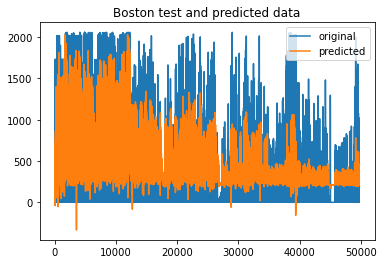

In [48]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.legend()
plt.show()